In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

import models
from datasets import load_dataset_classification, get_one_sample
from canary_utility import repack_model, get_preCanaryTrainable_variables_Conv2D
from utility import lr_schlr

In [2]:
dataset_key = "cifar100"
dataset_key_shadow = "cifar10"
batch_size_train = 64
batch_size_test = 64
rng_seed = 0
make_model = models.resnet18
# if pretrain model before canary injection (simulating FL)
pre_train = False

tf.random.set_seed(rng_seed)

# Load datasets

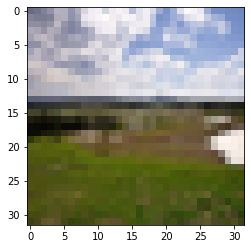

In [3]:
# load target for MIA 
pool_targets, x_shape, class_num = load_dataset_classification(dataset_key, batch_size_train, split='test')
# load local training set users for evaluation phase
dataset_validation, _, _ = load_dataset_classification(dataset_key, batch_size_test, split='train', repeat=1)
# load shadow dataset for canary injection
shadow, x_shape_s, _ = load_dataset_classification(dataset_key_shadow, batch_size_train, split='train')

assert x_shape_s == x_shape

x_target, y_target = get_one_sample(pool_targets)
plt.imshow((x_target[0]+1)/2);

# Setup model for target

In [4]:
model = make_model(x_shape, class_num)

if pre_train:
    ...

# Chosing canary location (i.e., $\xi$)

In [5]:
loss_function = models.sparse_classification_loss
#layer_idx = 37
layer_idx = 14
g_canary_shift = -2
kernel_idx = 0

model = repack_model(model, layer_idx, kernel_idx)
pre_canary_layer_trainable_variables = get_preCanaryTrainable_variables_Conv2D(model, layer_idx+1)

----> layer_normalization_3 (None, 8, 8, 128)
input_1

conv2d
	 conv2d/kernel:0
	 conv2d/bias:0

activation

max_pooling2d

layer_normalization
	 layer_normalization/gamma:0
	 layer_normalization/beta:0

activation_1

conv2d_1
	 conv2d_1/kernel:0
	 conv2d_1/bias:0

layer_normalization_1
	 layer_normalization_1/gamma:0
	 layer_normalization_1/beta:0

activation_2

conv2d_2
	 conv2d_2/kernel:0
	 conv2d_2/bias:0

tf.__operators__.add

layer_normalization_2
	 layer_normalization_2/gamma:0
	 layer_normalization_2/beta:0

activation_3

conv2d_3
	 conv2d_3/kernel:0
	 conv2d_3/bias:0

layer_normalization_3
	 layer_normalization_3/gamma:0
	 layer_normalization_3/beta:0



In [6]:
def make_loss(att, mask, W):
    loss = tf.keras.losses.MSE(att, mask)
    loss = loss * W
    loss = tf.reduce_mean(loss)
    return loss

def attack_iteration(model, x, mask, W, variables, opt):   
    with tf.GradientTape() as tape:
        _, att = model(x, training=True)    
        loss = make_loss(att, mask, W)  
        
    gradients = tape.gradient(loss, variables)
    opt.apply_gradients(zip(gradients, variables))
    return loss


def inject_canary(
    max_number_of_iters,
    batch_size,
    model,
    target,
    shadow_dataset,
    variables,
    opt,
    loss_threshold=0.0010,
    check_steps=10,
    min_num_iterations=1000,
):
    LOG = []

    canary_shape = model.output[1].shape.as_list()[1:]
    class_num = model.output[0].shape[1]
    
    
    mask = np.ones((batch_size, *canary_shape), np.float32) * -1
    mask[-1] = 1

    mask_b = np.ones((batch_size, 1), np.float32)
    mask_b[-1] = batch_size - 1

    loss_avg = 0.
    for i, batch in enumerate(shadow_dataset):
        x, _ = batch
        x = tf.concat([x[:-1], target], 0)
        loss = attack_iteration(model, x, mask, mask_b, variables, opt)
        loss = loss.numpy()
        
        loss_avg += loss
        
        if i % check_steps == 0:
            loss_avg /= check_steps
            LOG.append(loss)
            
            if loss_avg <= loss_threshold and i > min_num_iterations:
                print("Loss Threshold reached!")
                return LOG, True
                
            loss_avg = 0.

        if i > max_number_of_iters:
            print("Max number of iterations reached!")
            return LOG, False

    return LOG, False

Loss Threshold reached!


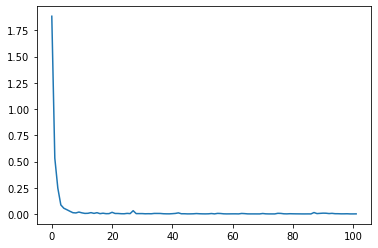

In [7]:
max_number_of_iters = 10000
init_lr = .01
#setps_lrs = [1000, 2000]
#opt = tf.keras.optimizers.Adam(lr_schlr(init_lr, setps_lrs))
opt = tf.keras.optimizers.Adam()
loss_threshold = 0.001

logs = inject_canary(
    max_number_of_iters,
    batch_size_train,
    model,
    x_target,
    shadow,
    pre_canary_layer_trainable_variables,
    opt,
    loss_threshold=loss_threshold
)

plt.plot(logs[0]);

In [8]:
from canary_utility import *

def evaluate_canary_attack(
    max_n,
    model,
    target,
    dataset_validation,
    variables,
    loss_function,
    g_canary_shift=-1,
    kernel_idx=0
):
    
    # tn fp
    neg = [0, 0]
    # tp fn
    pos = [0, 0]

    n = 0
    for i, batch in enumerate(dataset_validation):
        # batch without target
        negative, y = batch
        # batch with target (the label does not care)
        positive = tf.concat([negative[:-1], target], 0)

        neg_g, _ = get_gradient(negative, y, model, loss_function, variables)
        neg_g = get_canary_gradient(neg_g, g_canary_shift, kernel_idx).sum().tolist()
        
        pos_g, _ = get_gradient(positive, y, model, loss_function, variables)
        pos_g = get_canary_gradient(pos_g, g_canary_shift, kernel_idx).sum().tolist()

        neg[neg_g != 0] += 1
        pos[pos_g == 0] += 1
        
        n += 1

        if max_n and i >= max_n:
            print("Max number of iterations evaluation reached!")
            break

    acc = (neg[0] + pos[0]) / (n * 2)
    recall = pos[0] / n
    try:
        precision = pos[0] / (pos[0] + neg[1])
    except:
        precision = np.nan
    
    out = {
        'accuracy' : acc,
        'recall' : recall,
        'precision' : precision,
    }
    
    print("Number of iterations for evaluation:", i)

    return  out


out = evaluate_canary_attack(
    False,
    model,
    x_target,
    dataset_validation,
    pre_canary_layer_trainable_variables,
    loss_function,
    g_canary_shift=g_canary_shift,
    kernel_idx=kernel_idx
)

Number of iterations for evaluation: 780


In [9]:
out

{'accuracy': 0.9647887323943662,
 'recall': 1.0,
 'precision': 0.9342105263157895}